In [1]:
from __future__ import print_function, division
%matplotlib inline

# import used packages and modules
# import display function to display the table of the pandas dataframe
from IPython.display import display

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, confusion_matrix

from scipy import signal

from hmmlearn import hmm
from seqlearn.hmm import MultinomialHMM

import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import csv





/Users/mihaivisuian/miniconda3/envs/hons/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Importing Data

In [180]:
train_manchester = pd.read_csv('../data/misc/Train_Manchester_Northwich.csv')
london_data = pd.read_csv('../data/london_data/london_data.csv')

data04 = pd.read_csv('../data/meadows_december/meadows-2017-12-04.csv')
data05 = pd.read_csv('../data/meadows_december/meadows-2017-12-05.csv')
data06 = pd.read_csv('../data/meadows_december/meadows-2017-12-06.csv')
data07 = pd.read_csv('../data/meadows_december/meadows-2017-12-07.csv')

bike_data_old = pd.read_csv('../data/misc/2015061911.csv')
bike_data_old2 = pd.read_csv('../data/misc/2015061817.csv')
bike_data_feb = pd.read_csv('../data/misc/bike_feb.csv')

# Merging Data

In [150]:
bin_vals = ['bin'+str(x) for x in range(0,16)]
pm_vals = ['pm1', 'pm2_5', 'pm10']

In [185]:
# environment index is 0 as all data from these datasets is walking data
data04['environment_index'] = 0
data05['environment_index'] = 0
data06['environment_index'] = 0
data07['environment_index'] = 0

# environment index is 3 for bike data
bike_data_old['environment_index'] = 3
bike_data_old2['environment_index'] = 3
bike_data_feb['environment_index'] = 3

# rename columns
bike_data_old2 = bike_data_old2.rename(
    index=str, columns={"latitude":'gpsLatitude', "longitude":'gpsLongitude'})

labels = bin_vals + pm_vals + ['environment_index', 'gpsLatitude', 'gpsLongitude', 'humidity']

data = pd.concat([london_data[labels],
                  train_manchester[labels], 
                  data04[labels], 
                  data05[labels],
                  data06[labels],
                  data07[labels],
                  bike_data_old[labels],
                  bike_data_old2[labels],
                  bike_data_feb[labels]], ignore_index=True)

# remove indoor labelled data for this set of experiments
data = data[data['environment_index']!=7]
data = data[data['environment_index']!=5]
data = data[data['humidity']>0]

### Data Information

In [186]:
data.describe()

,bin0,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,...,bin13,bin14,bin15,pm1,pm2_5,pm10,environment_index,gpsLatitude,gpsLongitude,humidity
count,3970.000000,3970.000000,3970.000000,3970.000000,3970.000000,3970.000000,3970.000000,3970.000000,3970.000000,3970.000000,...,3970.000000,3970.000000,3970.000000,3970.000000,3970.000000,3970.000000,3970.000000,3970.000000,3970.000000,3970.000000
mean,417.945088,105.518136,62.766247,37.194458,13.818388,12.804786,7.402519,3.714106,4.959950,3.422670,...,0.219647,13.790176,8.835264,4.445759,9.611883,22.207614,1.902519,54.685102,-2.599240,53.165118
std,941.266986,243.487853,139.392366,74.114230,27.341315,25.552281,27.309803,56.265748,160.067557,151.109326,...,1.506387,682.987493,379.290387,9.143567,12.674980,55.742419,1.460945,5.859238,1.066219,9.991877
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-3.258313,17.600000
25%,14.000000,4.000000,3.000000,2.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.265332,3.417454,5.495040,0.000000,55.835090,-3.193039,46.299999
50%,135.000000,46.000000,32.000000,19.000000,6.000000,6.000000,3.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.160299,6.198611,9.479655,2.000000,55.942776,-3.186589,53.696285
75%,469.750000,114.000000,73.000000,47.000000,17.000000,16.000000,8.000000,2.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,4.486784,11.249292,19.693625,3.000000,55.945289,-2.338986,57.602979
max,12336.000000,4758.000000,3710.000000,1997.000000,538.000000,434.000000,656.000000,3343.000000,7955.000000,9500.000000,...,29.000000,40962.000000,16999.000000,108.471610,158.405240,1051.750977,6.000000,56.008247,-0.100202,89.800000


### Labels

In [187]:
labels_idx = np.array([0, 1, 2, 3, 4, 6])

# Kmeans

In [188]:
# method to get the cluster means of the data points based on coordinates
# and the queried columns
def get_location_cluster_means(data, cluster_no, cols):
    # obtain indices of clusters
    kmeans = KMeans(n_clusters=cluster_no, random_state=0)
    # remove data rows with null coordinates
    data = data[~np.isnan(data['gpsLatitude'])]
    # get the indices of the location based clusters
    indices = kmeans.fit_predict(data[['gpsLatitude', 'gpsLongitude']])
    freqs = np.bincount(indices)
    # initialise means of queried columns
    means = np.zeros((cluster_no, len(cols)))
    # assign clustered_indices to dataframe
    data['clustered_index'] = indices
    # compute means of queried columns
    for index in np.unique(indices):
        means[index] = np.mean(data[data['clustered_index'] == index][cols])
    return means, data

In [189]:
# method to get the clusters of the environments corresponding to the 5 environments based on
# the queried columns and number of location clusters
def get_environment_clusters(data, cluster_no, cols):
    means, d = get_location_cluster_means(data, cluster_no, cols)
    # we have 5 clusters corresponding to 6 different types of transport
    environment_kmeans = KMeans(n_clusters=6, random_state=0)
    # predict the cluster indices
    environment_indices = environment_kmeans.fit_predict(means)
    # sort the indices based on the means of the clusters
    idx = np.argsort(environment_kmeans.cluster_centers_.sum(axis=1))
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(6)
    # append the indices to the dataframe
    d['unsupervised_environment_index'] = lut[environment_indices][d['clustered_index']]
    return d

# Stats Methods

In [190]:
def plot_confusion_matrix(labels, predictions, title='Confusion matrix', 
                          classes=['on_foot', 'car', 'train', 'bike', 'bus', 'underground']):
    """Plots a confusion matrix."""
    cmatrix = np.array(confusion_matrix(labels, predictions))
    # normalize confusion matrix
    cm = cmatrix/cmatrix.sum(axis=1)[:, np.newaxis]
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True data')
    plt.xlabel('Predicted data')
    plt.show()

In [208]:
def get_training_accuracy_with_kfolds_iloc(estimator, x_tr, y_tr, kf):
    score_array = np.empty(kf.n_folds)
    
    for (idx, (train_feature, test_feature)) in enumerate(kf):
        estimator.fit(x_tr.iloc[train_feature], y_tr.iloc[train_feature])
        y_pred = estimator.predict(x_tr.iloc[test_feature])
        cm = confusion_matrix(y_tr.iloc[test_feature], y_pred)
        cm_norm = cm.astype('float')/cm.sum(axis=1)
        score_array[idx] = accuracy_score(y_tr.iloc[test_feature], y_pred, normalize=True)
        
#         plot_confusion_matrix(y_tr.iloc[test_feature], y_pred)
        
    return np.mean(score_array)

In [192]:
def get_training_accuracy_mixed_models(estimators, x_tr, y_tr, kf):
    score_array = np.empty(kf.n_folds)
    
    for (idx, (train_feature, test_feature)) in enumerate(kf):
        probs_array = np.empty((len(estimators), x_tr.iloc[test_feature].shape[0], 6))

        for estimator_idx, estimator in enumerate(estimators):
            estimator.fit(x_tr.iloc[train_feature], y_tr.iloc[train_feature])
            probs_array[estimator_idx] = estimator.predict_proba(x_tr.iloc[test_feature])
        
        final_labels = labels_idx[np.argmax(np.mean(probs_array, axis=0), axis=1)]
        score_array[idx] = accuracy_score(y_tr.iloc[test_feature], final_labels, normalize=True)
    
    return np.mean(score_array)

# Best Models

In [209]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['bin0']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

rf = RandomForestClassifier(random_state=0, n_estimators=260, n_jobs=-1)
kf = KFold(len(clustered_normalised_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, clustered_normalised_data[['unsupervised_environment_index', 'humidity']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.954971274944


### Removing Underground Data

In [194]:
filtered_data = data[data['environment_index']!=6]

clustered_data = get_environment_clusters(filtered_data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['bin0']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

rf = RandomForestClassifier(random_state=0, n_estimators=260, n_jobs=-1)
kf = KFold(len(clustered_normalised_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(rf, clustered_normalised_data[['unsupervised_environment_index', 'humidity']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.964412703691


### Neural Network

In [196]:
# environment clustering on raw bin values: 3 hidden layers
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['bin0']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5, 
                    hidden_layer_sizes=(20,), 
                    random_state=1, 
                    max_iter=500)
kf = KFold(len(clustered_normalised_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(clf, clustered_normalised_data[['unsupervised_environment_index']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.822659988158


### KNN

In [197]:
clustered_data = get_environment_clusters(data, 40, bin_vals)

clustered_normalised_data = clustered_data[clustered_data['bin0']>0].copy().reindex()
clustered_normalised_data[bin_vals] = clustered_normalised_data[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
kf = KFold(len(clustered_normalised_data), n_folds=5, shuffle=True, random_state=0)

print("Accuracy:", get_training_accuracy_with_kfolds_iloc(knn, clustered_normalised_data[['unsupervised_environment_index', 'humidity']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf))

Accuracy: 0.849734513274


### Mixed Model

In [198]:
kf = KFold(len(clustered_normalised_data), n_folds=5, shuffle=True, random_state=0)

get_training_accuracy_mixed_models([knn, rf, clf], clustered_normalised_data[['unsupervised_environment_index', 'humidity']+bin_vals], 
                                                          clustered_normalised_data['environment_index'], kf)

0.9256256301108996

### Validating Models

#### Bike validation data

In [211]:
bike_data_validation = pd.read_csv('../data/misc/20150618.csv')
bike_data_validation['environment_index'] = 3

bike_data_validation = bike_data_validation.rename(index=str, columns={"latitude":'gpsLatitude', "longitude":'gpsLongitude'})
display(bike_data_validation.describe())

,time,gpsLatitude,gpsLongitude,bin0,bin1,bin2,bin3,bin4,bin5,bin6,...,opctemp,temperature,humidity,alphaVersion,urban_space,o3_ae,o3_we,no2_ae,no2_we,environment_index
count,9.650000e+02,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,...,0.0,965.000000,965.000000,965.0,965.000000,965.000000,965.000000,965.000000,965.000000,965.0
mean,2.015062e+13,50.514721,-2.980726,9.733679,1.862176,1.346114,0.905699,0.656995,1.061140,0.613472,...,NaN,20.137565,43.524566,2.0,-0.095337,-7284.846632,-5096.067358,-10171.590674,-7158.012435,3.0
std,5.592194e+02,16.731824,0.643371,6.295997,1.646280,1.245905,1.012586,0.832101,1.103273,0.803793,...,NaN,1.031035,1.808220,0.0,0.293832,11283.184351,11737.250969,10599.945141,11277.604430,0.0
min,2.015062e+13,-1.000000,-3.203215,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,19.160000,39.695680,2.0,-1.000000,-30686.000000,-29406.000000,-32734.000000,-30942.000000,3.0
25%,2.015062e+13,55.940717,-3.194135,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,19.460000,41.923517,2.0,0.000000,-16094.000000,-15070.000000,-17630.000000,-16094.000000,3.0
50%,2.015062e+13,55.943865,-3.186613,9.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,NaN,19.760000,44.266320,2.0,0.000000,-2782.000000,1059.000000,-6878.000000,-2270.000000,3.0
75%,2.015062e+13,55.945240,-3.181847,13.000000,3.000000,2.000000,1.000000,1.000000,2.000000,1.000000,...,NaN,20.200000,44.978877,2.0,0.000000,2339.000000,4387.000000,-3038.000000,2339.000000,3.0
max,2.015062e+13,55.946557,-1.000000,119.000000,10.000000,7.000000,6.000000,5.000000,6.000000,4.000000,...,NaN,23.240000,46.238251,2.0,0.000000,9251.000000,10531.000000,6947.000000,8227.000000,3.0


Validation accuracy: 0.976817702845


/Users/mihaivisuian/miniconda3/envs/hons/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


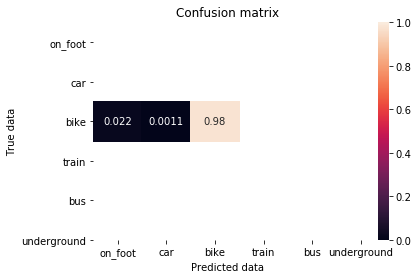

In [210]:
clustered_validation_data = get_environment_clusters(bike_data_validation, 40, bin_vals)

clustered_normalised = clustered_validation_data[clustered_validation_data['bin0']>0].copy().reindex()
clustered_normalised[bin_vals] = clustered_normalised[bin_vals].apply(lambda row: row/np.sum(row), axis=1)

predictions = rf.predict(clustered_normalised[bin_vals+['unsupervised_environment_index', 'humidity']])

print("Validation accuracy:", accuracy_score(clustered_normalised['environment_index'], predictions))

plot_confusion_matrix(clustered_normalised['environment_index'], predictions, 
                      classes=['on_foot', 'car', 'bike', 'train', 'bus', 'underground'])

#### Walking validation data